In [1]:
import pennylane as qml
import torch
import numpy as np
import os, pandas as pd, random, gc
from collections import defaultdict
from typing import List, Tuple, Dict

# === 基本設定 ===
N = 18
m = 2
device = torch.device("cpu")

#--------------------------------------------------#
def generate_case(seed=42):
    def generate_bbv_graph(
        N: int,
        m: int,
        seed: int | None = None,
        m0: int | None = None,
        w0: float = 1.0,
        delta: float = 1.0
    ) -> Tuple[List[Tuple[int, int]], List[float], List[float], List[int]]:
        """
        產生 BBV (Barrat–Barthelemy–Vespignani) 加權網路。

        回傳：
        edges:   [(u,v), ...]（u<v）
        weights: [w_uv, ...] 與 edges 對齊
        strength: [s_i]  每個節點的加權度數 s_i = sum_j w_ij
        """
        assert 1 <= m < N, "需滿足 1 <= m < N"
        if m0 is None:
            m0 = m
        assert m0 >= m and m0 <= N
        assert w0 >= 0 and delta >= 0
        rng = random.Random(seed)

        adj: Dict[int, Dict[int, float]] = defaultdict(dict)
        strength = [0.0] * N

        # 初始 K_{m0}
        for i in range(m0):
            for j in range(i + 1, m0):
                adj[i][j] = w0
                adj[j][i] = w0
                strength[i] += w0
                strength[j] += w0

        def weighted_sample_without_replacement(pop_indices: List[int], weights: List[float], k: int) -> List[int]:
            if sum(weights) <= 0:
                return rng.sample(pop_indices, k)
            chosen = []
            pool = pop_indices[:]
            w = weights[:]
            for _ in range(k):
                pick = rng.choices(pool, weights=w, k=1)[0]
                idx = pool.index(pick)
                chosen.append(pick)
                pool.pop(idx); w.pop(idx)
            return chosen

        for new_v in range(m0, N):
            candidates = list(range(new_v))
            weights_s = [strength[u] for u in candidates]
            targets = weighted_sample_without_replacement(candidates, weights_s, m)

            for u in targets:
                s_u_old = strength[u]
                if s_u_old > 0 and delta > 0:
                    increments = []
                    for v, w_uv in adj[u].items():
                        inc = delta * w_uv / s_u_old
                        if inc > 0:
                            increments.append((v, inc))
                    for v, inc in increments:
                        adj[u][v] += inc
                        adj[v][u] += inc
                        strength[u] += inc
                        strength[v] += inc

                if u not in adj[new_v]:
                    adj[new_v][u] = 0.0
                    adj[u][new_v] = 0.0
                adj[new_v][u] += w0
                adj[u][new_v] += w0
                strength[new_v] += w0
                strength[u]     += w0

        edges = []
        weights = []
        for u in range(N):
            for v, w in adj[u].items():
                if u < v:
                    edges.append((u, v))
                    weights.append(w)
        return edges, weights, strength

    edges, weights, deg_w = generate_bbv_graph(
        N=N, m=m, seed=seed, m0=None, w0=1.0, delta=1
    )
    weights = torch.tensor(weights, device=device, dtype=torch.float32)

    # --- 成本向量（為了計算 MaxCut 最佳值，用暴力法） ---
    num_states = 2 ** N
    states = torch.arange(num_states, device=device).unsqueeze(1)
    bits = ((states >> torch.arange(N, device=device)) & 1).bool()  # LSB->MSB
    costs = torch.zeros(num_states, device=device, dtype=torch.float32)
    for idx, (i, j) in enumerate(edges):
        diff = bits[:, i] ^ bits[:, j]
        costs += weights[idx] * diff.float()

    print(f"Min: {costs.min():.4f}, Mean: {costs.mean():.4f}, Max: {costs.max():.4f}")

    # --- 也建立 expval 用的 Hamiltonian（常數 + ZZ 形式） ---
    coeffs = []
    observables = []
    for (i, j), w in zip(edges, weights.tolist()):
        coeffs.append(0.5 * w)                        # 常數項 * I
        observables.append(qml.Identity(0))
        coeffs.append(-0.5 * w)                       # -0.5 w Z_i Z_j
        observables.append(qml.PauliZ(i) @ qml.PauliZ(j))
    cost_hamiltonian = qml.Hamiltonian(coeffs, observables)

    return weights, edges, deg_w, costs, cost_hamiltonian

#--------------------------------------------------#

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# === 建立圖形並加上權重 ===
def plot_graph(edges, weights):
    G = nx.Graph()
    for (edge, w) in zip(edges, weights):
        G.add_edge(edge[0], edge[1], weight=w)

    # 取得加權度數 (weighted degree)
    weighted_deg = dict(G.degree(weight="weight"))

    # 按加權度數排序（由大到小）
    nodes_sorted = sorted(G.nodes(), key=lambda x: weighted_deg[x], reverse=True)

    # 重新分配角度 (逆時針)
    n = len(nodes_sorted)
    angles = np.linspace(0, 2*np.pi, n, endpoint=False)
    pos = {node: np.array([np.cos(theta), np.sin(theta)]) for node, theta in zip(nodes_sorted, angles)}

    # 邊寬正規化
    max_w, min_w = max(weights), min(weights)
    edge_widths = [1 + 4 * (G[u][v]['weight'] - min_w) / (max_w - min_w) for u, v in G.edges()]

    # 畫圖，並在節點旁顯示加權度數
    plt.figure(figsize=(8, 8))
    nx.draw_networkx_nodes(G, pos, node_size=400, node_color="skyblue", edgecolors="black")
    nx.draw_networkx_edges(G, pos, width=edge_widths)

    # 標籤改成「節點號碼 (加權度數)」
    labels = {node: f"{node}" for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)

    plt.axis("off")
    plt.title("A BBV network instance of N=12")
    plt.show()


Min: 0.0000, Mean: 32.5000, Max: 51.1357


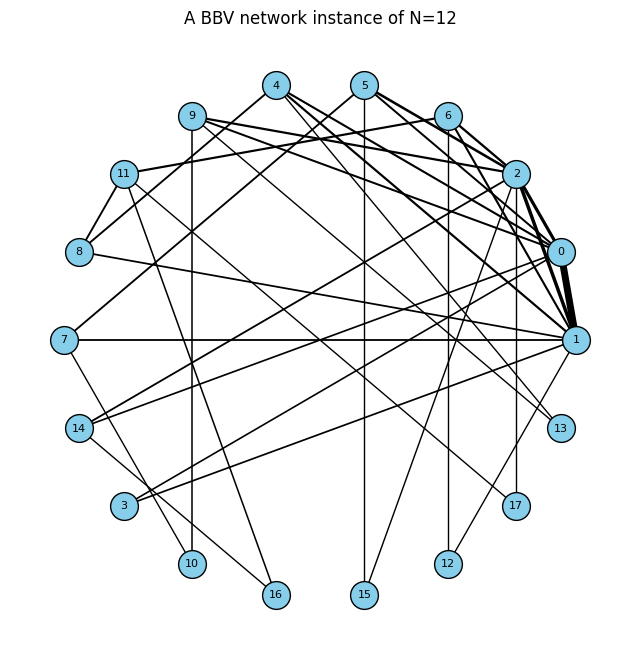

Min: 0.0000, Mean: 32.5000, Max: 48.3902


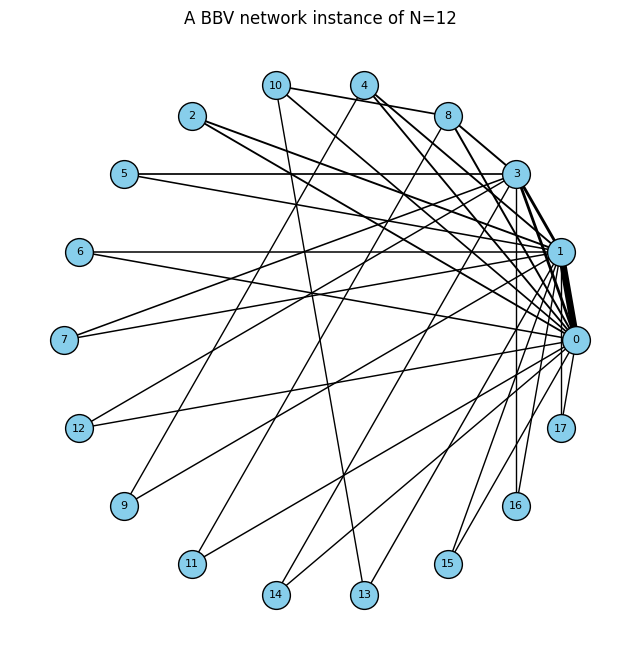

Min: 0.0000, Mean: 32.5000, Max: 47.7499


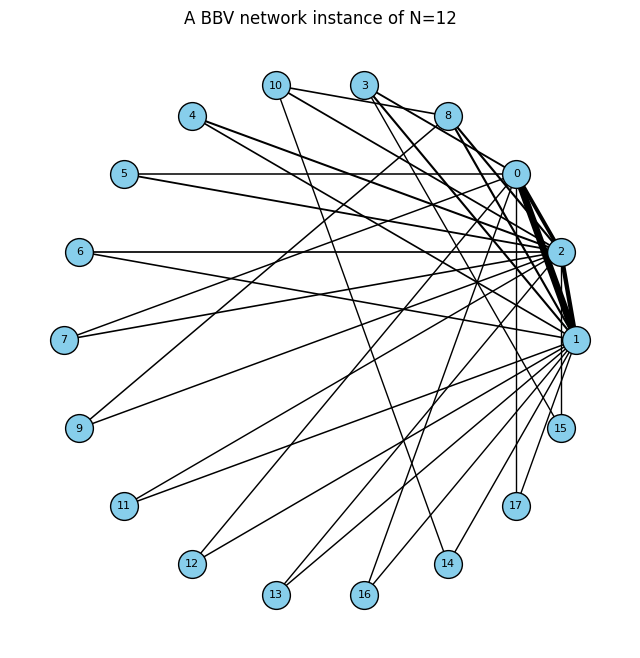

Min: 0.0000, Mean: 32.5000, Max: 50.6363


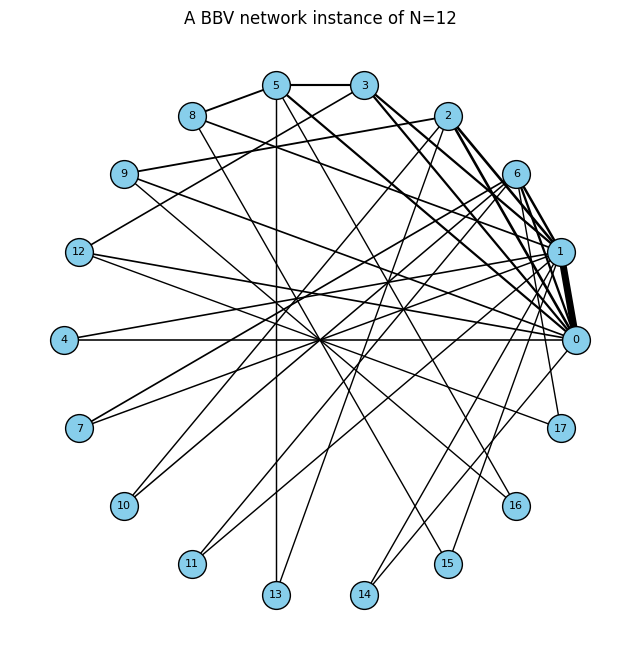

Min: 0.0000, Mean: 32.5000, Max: 48.2897


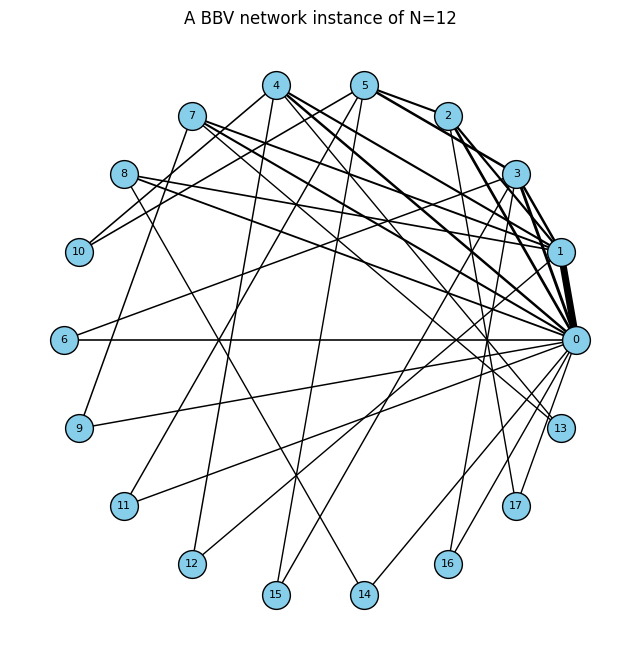

Min: 0.0000, Mean: 32.5000, Max: 49.0868


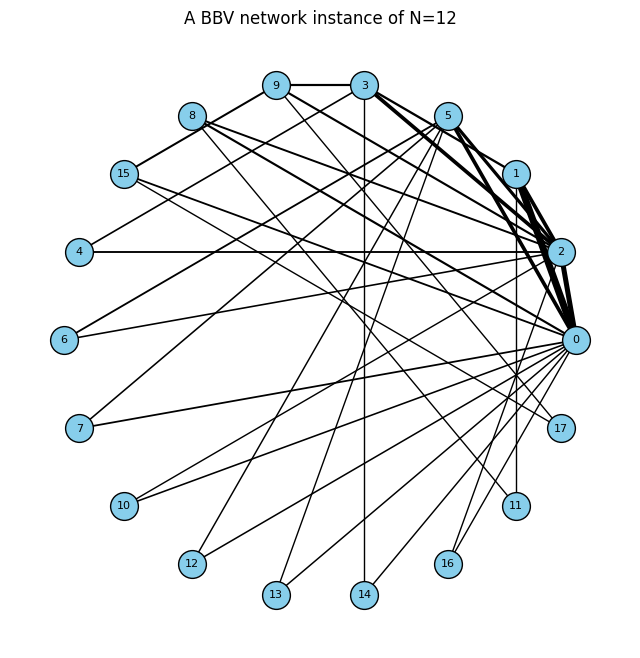

Min: 0.0000, Mean: 32.5000, Max: 51.0615


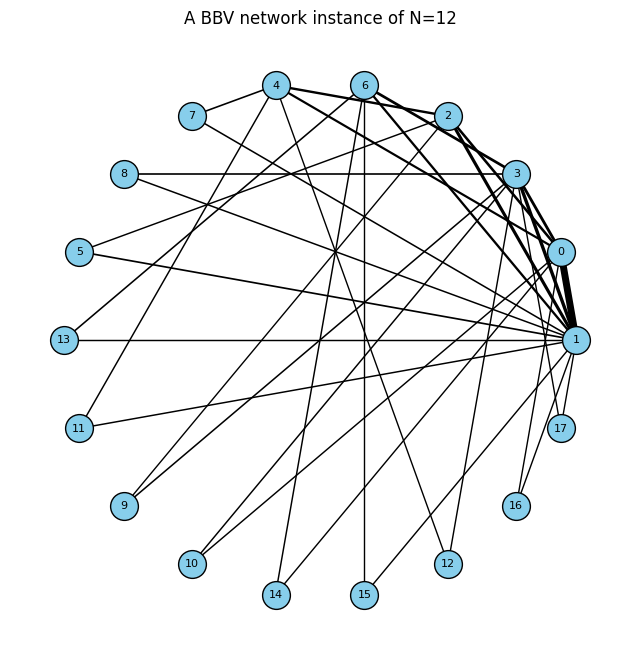

Min: 0.0000, Mean: 32.5000, Max: 46.9762


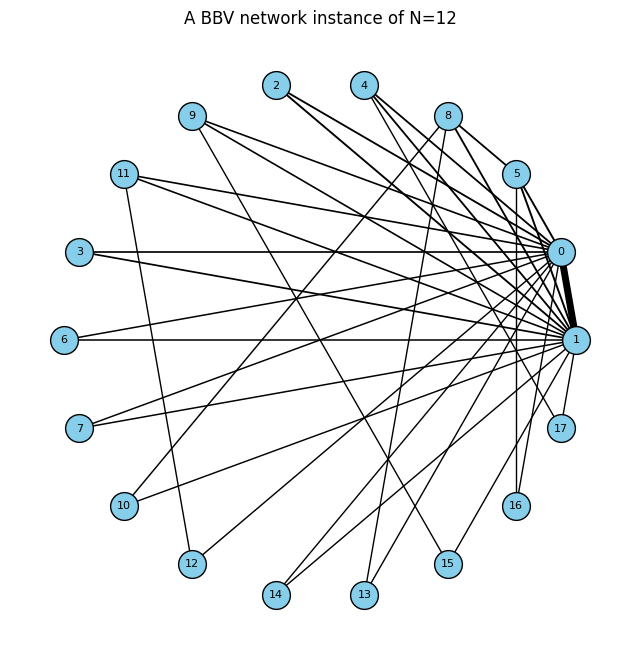

Min: 0.0000, Mean: 32.5000, Max: 49.6098


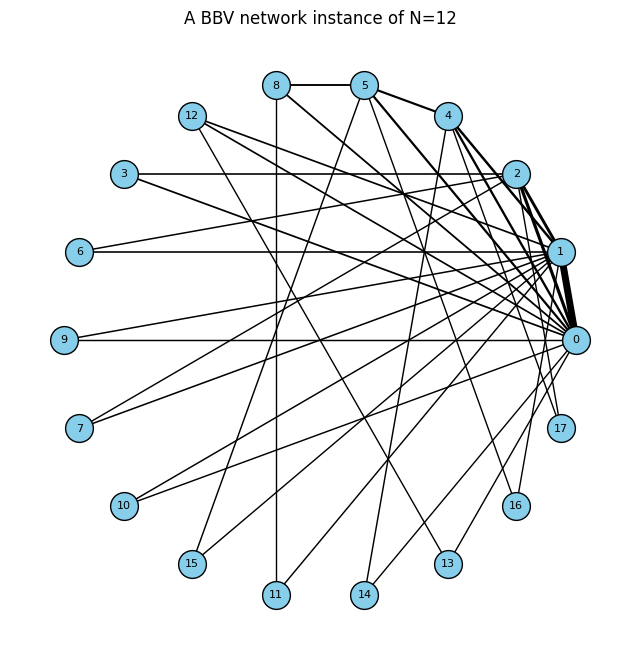

Min: 0.0000, Mean: 32.5000, Max: 48.3876


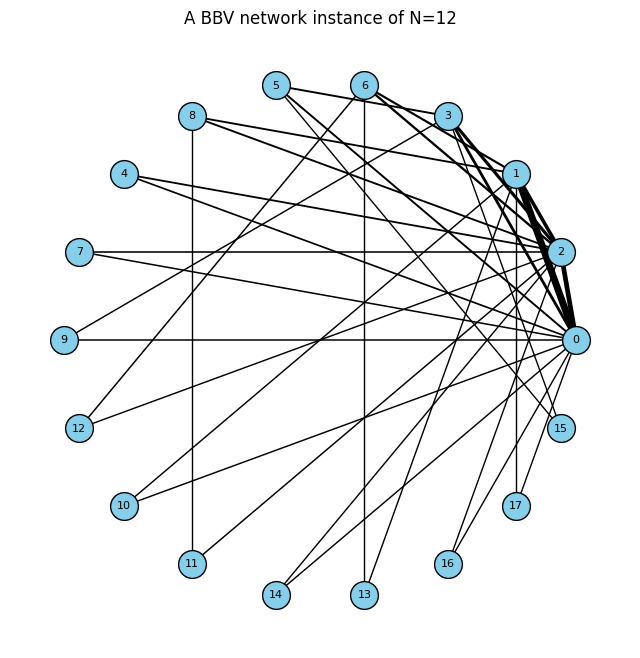

Min: 0.0000, Mean: 32.5000, Max: 48.0348


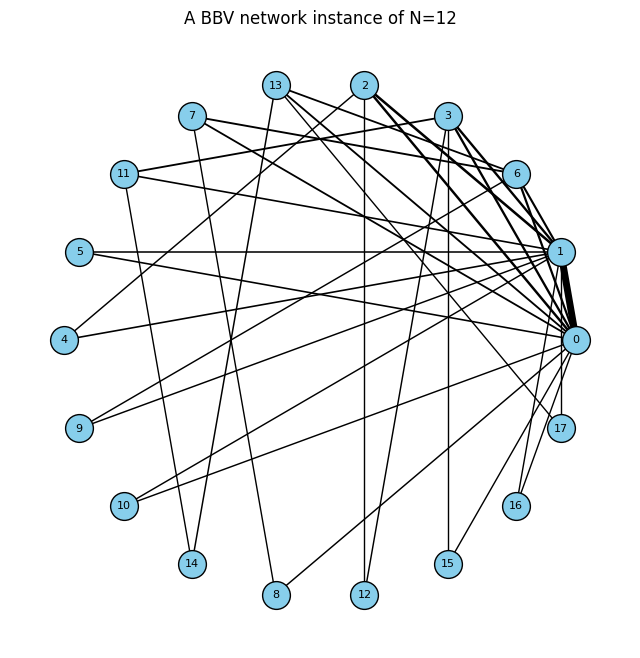

Min: 0.0000, Mean: 32.5000, Max: 48.1883


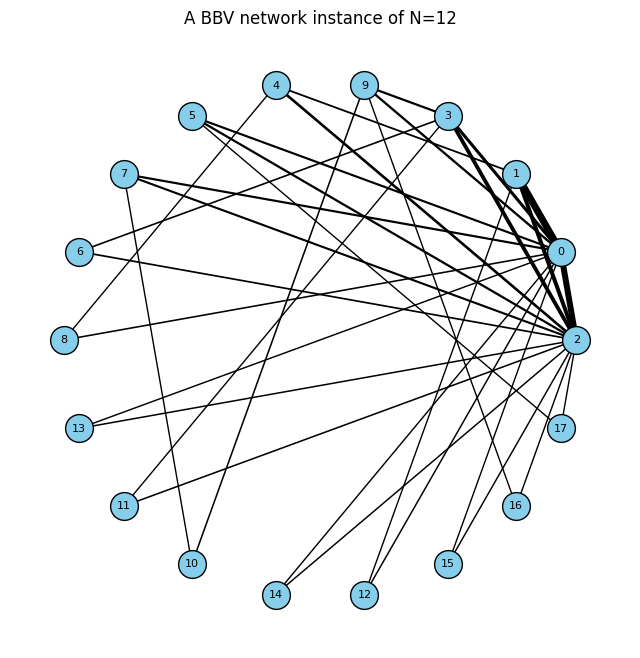

Min: 0.0000, Mean: 32.5000, Max: 50.8907


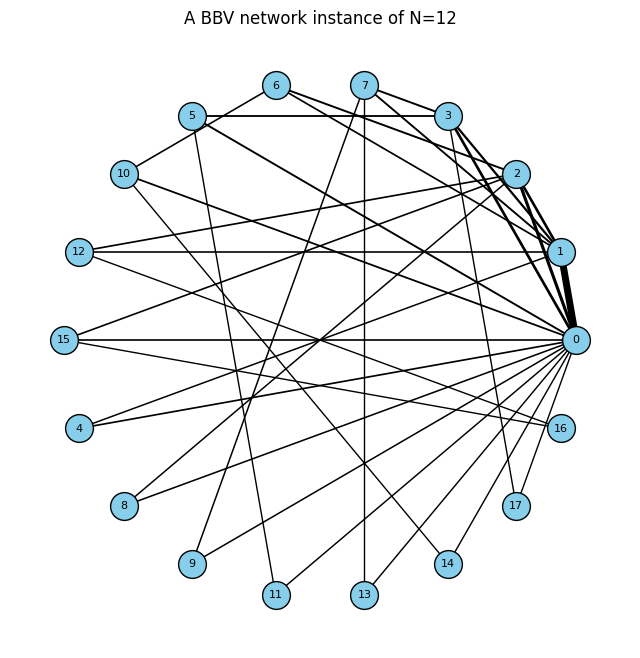

Min: 0.0000, Mean: 32.5000, Max: 49.1035


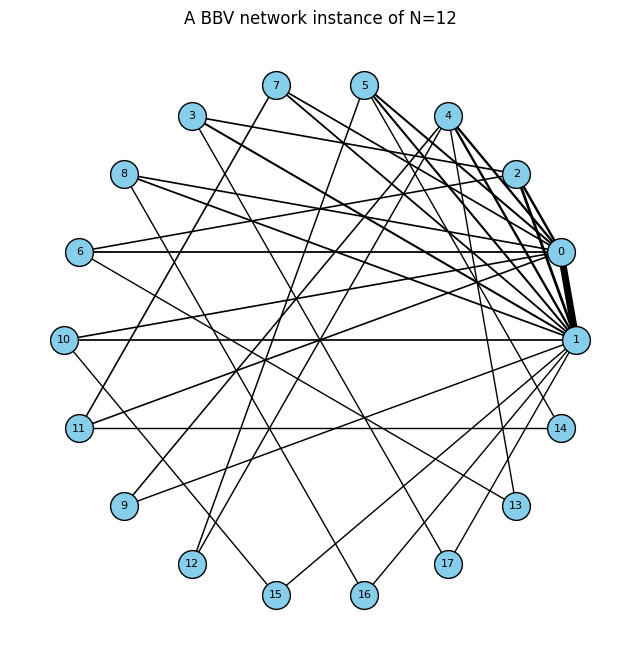

Min: 0.0000, Mean: 32.5000, Max: 46.9102


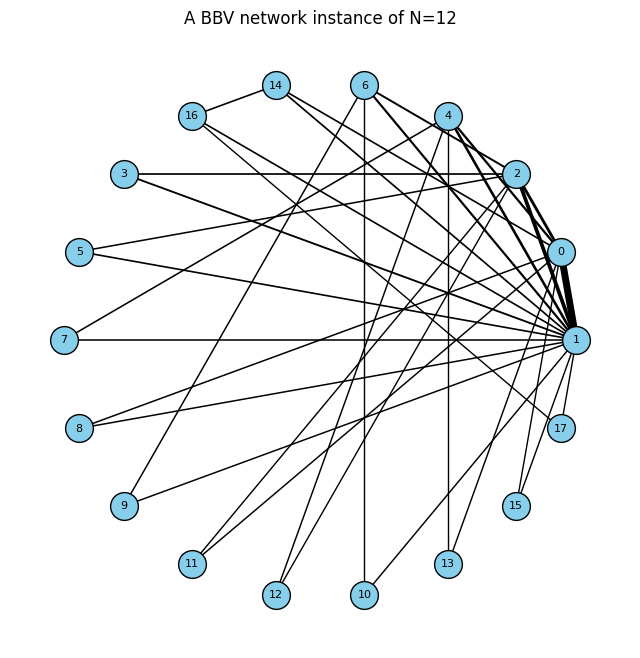

Min: 0.0000, Mean: 32.5000, Max: 48.8192


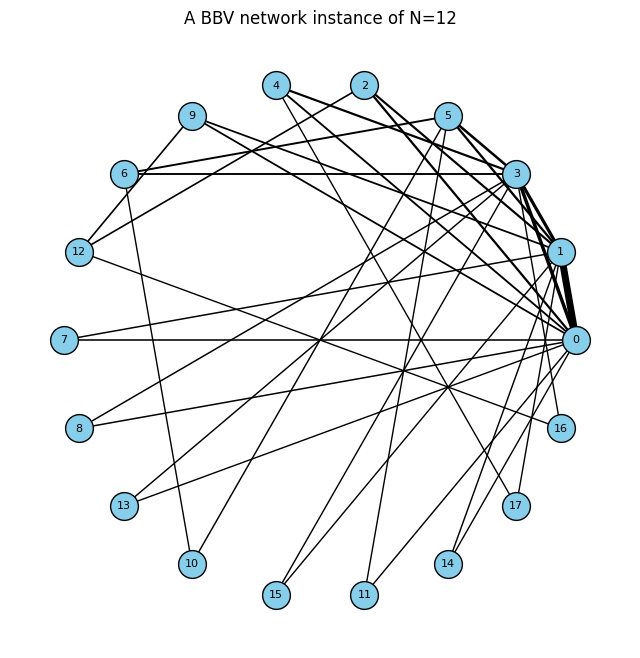

Min: 0.0000, Mean: 32.5000, Max: 48.8752


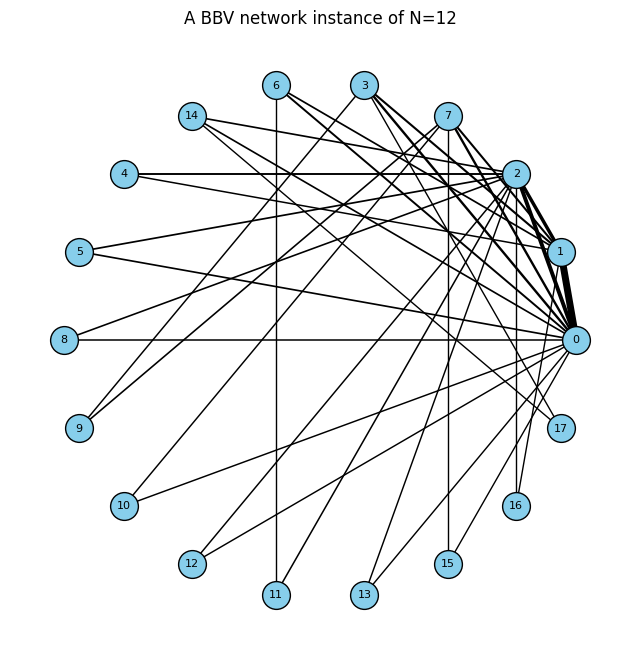

Min: 0.0000, Mean: 32.5000, Max: 51.3977


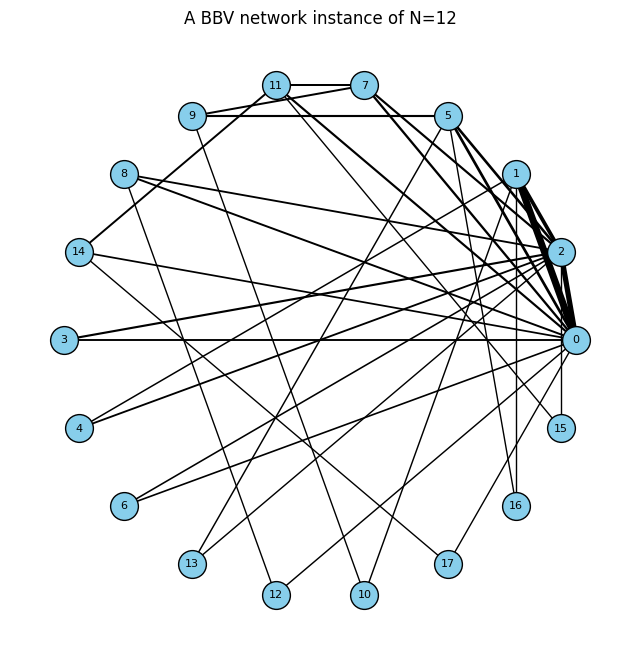

Min: 0.0000, Mean: 32.5000, Max: 48.4448


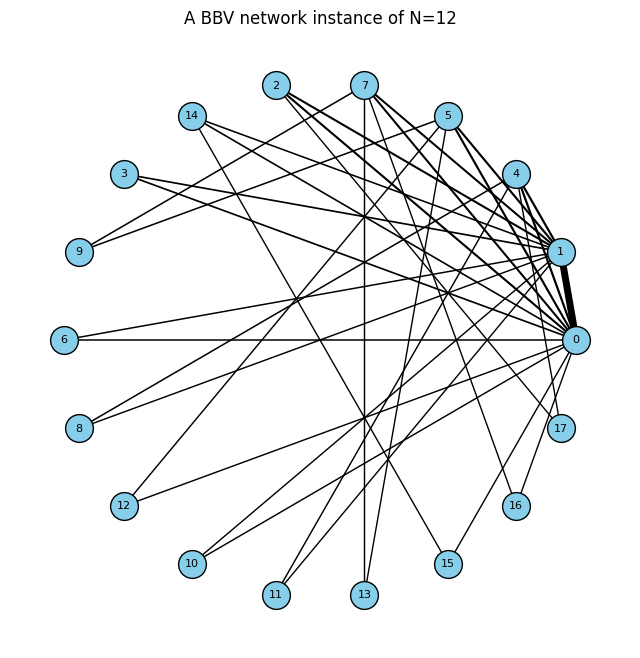

Min: 0.0000, Mean: 32.5000, Max: 49.3431


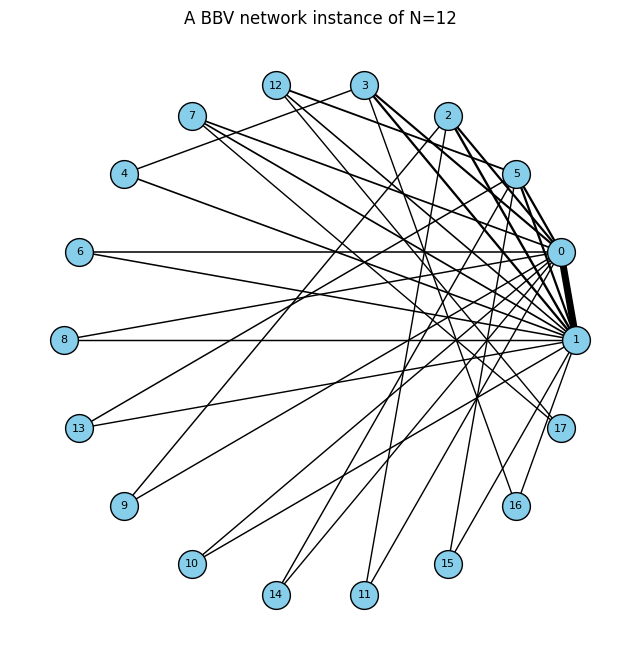

In [3]:
for instance_id in range(20):
    weights, edges, deg_w, costs, cost_hamiltonian = generate_case(instance_id)
    plot_graph(edges, weights)
    